In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset import ThermDataset
%matplotlib inline

## Parameters 

In [2]:
args = {'lr':0.01,
        'batch_size':32,
        'epochs':1000,
        'noise':0.001,
        'direction':0,
        'train_size':0.7
        }

# Prepare Data

In [3]:
dataset = ThermDataset(fp='combined_data.xlsx', direction=args['direction'], noise_scale=args['noise'], tandem=1)

In [4]:
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

# Design Model 
(input size, output size, forward pass)

In [6]:
# spec in temp out
class SubNN(nn.Module):
    def __init__(self, spec_size, temp_size):
        super(SubNN, self).__init__()
        self.lin1 = nn.Linear(spec_size, 45)
        self.lin_fin = nn.Linear(45, temp_size)


    def forward(self, x):
        output = F.relu(self.lin1(x))
        output = self.lin_fin(output)
        return output

In [7]:
# temp in spec out
class MainNN(nn.Module):
    def __init__(self, temp_size, spec_size):
        super(MainNN, self).__init__()
        self.subnet = SubNN(spec_size=spec_size, temp_size=temp_size) # spec in temp out
        self.lin = nn.Linear(temp_size, spec_size) # temp in spec out


    def forward(self, x):
        spec_pred = self.subnet(x)
        temp_pred = self.lin(spec_pred)
        return temp_pred

In [8]:
n_samples = len(train_dataset)
_, temp_size = dataset.x.shape
_, spec_size = dataset.y.shape

model = MainNN(temp_size=temp_size, spec_size=spec_size)

# Construct Loss and Optimizer

In [9]:
learning_rate = args['lr']
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [10]:
num_epochs = args['epochs']
loss_list = []
temp_loss_list = []
spec_loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:
        # empty gradients
        optimizer.zero_grad()

        # forward pass and loss
        spec_pred = model(spec_batch)
        temp_pred = model.subnet(spec_batch)

        # get loss
        spec_loss = criterion(spec_pred, spec_batch)
        temp_loss = criterion(temp_pred, temp_batch)

        # backward pass
        temp_loss.backward()

        # update
        optimizer.step()

        

    loss_list.append(temp_loss.item())
    spec_loss_list.append(spec_loss.item())
    temp_loss_list.append(temp_loss.item())

    if temp_loss < best_loss:
        best_loss = temp_loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/5) == 0:
        print(f'epoch: {epoch+1}, spectrum loss = {spec_loss:.6f}, temperature loss = {temp_loss:.6f}')

print(f'\nbest loss: {best_loss} in epoch: {best_epoch}')

epoch: 200, spectrum loss = 31048.253906, temperature loss = 167.220596
epoch: 400, spectrum loss = 29512.855469, temperature loss = 74.095390
epoch: 600, spectrum loss = 29582.029297, temperature loss = 100.408691
epoch: 800, spectrum loss = 28516.917969, temperature loss = 145.656937
epoch: 1000, spectrum loss = 29190.593750, temperature loss = 152.763321

best loss: 35.04929733276367 in epoch: 776


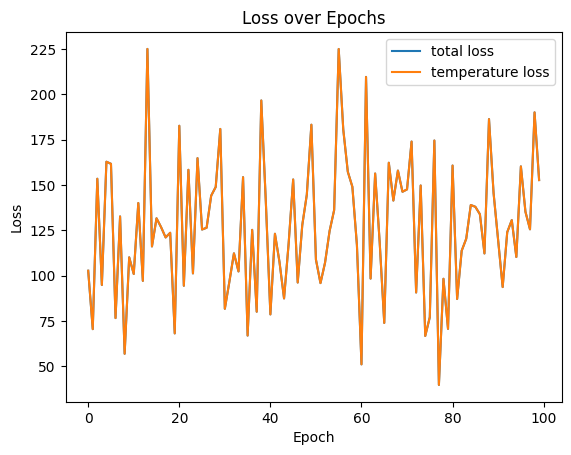

In [11]:
plt.plot(loss_list[-100:], label='total loss')
#plt.plot(spec_loss_list[20:], label='spectrum loss')
plt.plot(temp_loss_list[-100:], label='temperature loss')

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

# Testing

In [12]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index):
    actual_np = actual[index]
    pred_np = pred[index]


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, 'r+', label='predicted')

    if args['direction']:
        plt.title("Temperature to Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectrum to Temperature")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

In [13]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for temp_batch, spec_batch in test_loader:
        inputs = X_batch
        actual = y_batch

        pred = model(inputs)
        loss = criterion(pred, actual)
        total_loss += loss.item() * len(X_batch)
        n_samples += len(X_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(pred.numpy(), actual.numpy(), 0) 

average_loss = total_loss/n_samples
print(f"average loss: {average_loss}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x11 and 66x45)